総フレーム数:  449.0
fps:  29.97002997002997
動画の長さ:  14.981633333333333 [sec]
720
60


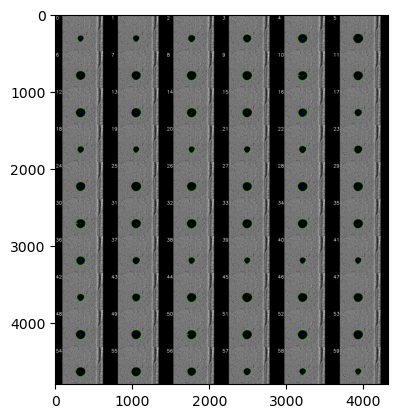

1 pixel is approximately 0.0353 mm


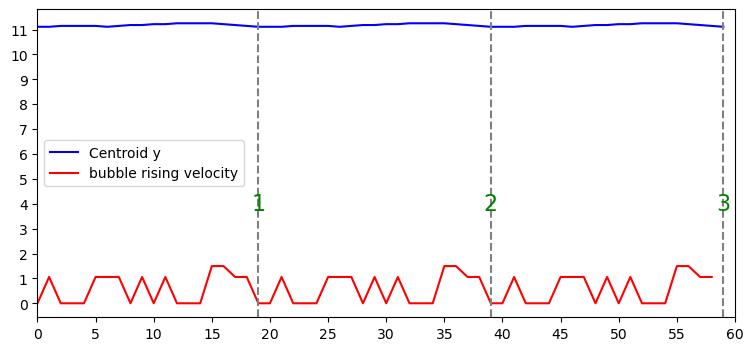

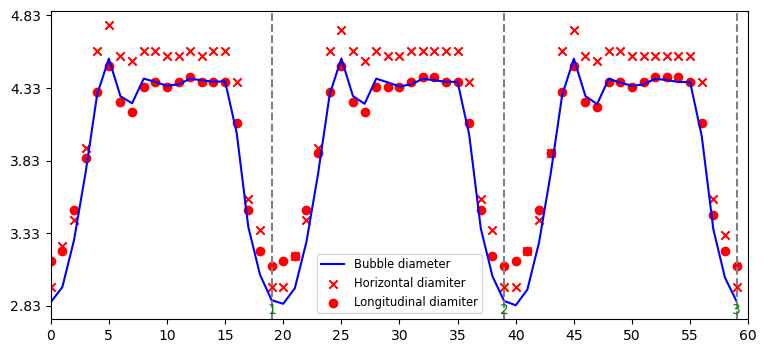

True

In [5]:
import cv2
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd 
import pixel_converter
#from assemble_frames import assemble_frames
from assemble_frames_with_order_numbers import assemble_frames_with_order_numbers
from table_image_generator import create_table_image, find_min_max_avg_table
from video_converter import create_video_from_images

# ビデオデータの読み込み
filename = "C:\\Users\\flow\\Desktop\\bubbledate\\kasupuGray.mp4"
base_path= "C:\\Users\\flow\\Desktop\\bubble_rasing_result\\"
# 動画ファイルのベース名を取得
video_base_name = os.path.splitext(os.path.basename(filename))[0]

# 動画ごとのディレクトリを作成
video_directory = os.path.join(base_path, video_base_name)
os.makedirs(video_directory, exist_ok=True)  # 既に存在している場合は作成しない
# 新しいフォルダのベース名を指定
folder_names = ["d_image", "d_contours", "d_result", "d_threshold", "d_graph"]

# 新しいフォルダを作成
for folder_name in folder_names:
    new_folder_path = os.path.join(video_directory, folder_name)
    os.makedirs(new_folder_path, exist_ok=True)

# 動画の読み込み
cap = cv2.VideoCapture(filename=filename)
#動画ファイルの情報を取得する
width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
hight = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
total_frame = cap.get(cv2.CAP_PROP_FRAME_COUNT)
fps = cap.get(cv2.CAP_PROP_FPS)
print("総フレーム数: ", total_frame)
print("fps: ", fps)
print("動画の長さ: ", total_frame/fps, "[sec]")

# 動画のdpiを取得
video_path = filename
dpi = pixel_converter.get_video_dpi(video_path)
print(dpi)


frame_count = 0  # フレームのカウントを初期化
prev_cx = None  # 前のフレームの重心 x 座標
prev_cy = None  # 前のフレームの重心 y 座標
# グラフ用のデータ格納リスト
area_data = []
perimeter_data = []
moment_data = []
# 重心のy座標を格納するリスト
centroid_y_data = []
speed_data = []  # 速度情報を格納するリスト、最初の値を0に初期化
sphere_radiuses = []
# ㎜単位の速度情報を格納するリスト
speed_mm_per_s_data = []
# ㎜単位の重心y座標を格納するリスト
centroid_y_mm_data = []
# ㎜単位の気泡半径を格納するリスト
sphere_radius_mm_data = []
# フレームを格納するリスト
frames = []
# 水平方向と鉛直方向の気泡径のデータを格納するリスト
base_lengths = []
heights = []
base_length_mm_data = []
height_mm_data = []


# 開始フレームを設定
start_frame = 45 
# 開始フレームまで読み込む
for _ in range(start_frame):
    ret, _ = cap.read()
    if not ret:
        print("Error: Failed to read frames.")
        sys.exit(1)

while cap.isOpened() and frame_count < 60:  # 90枚分の処理を行う
    ret, frame = cap.read()
    if ret:   
        num = frame_count
        path = os.path.join(video_directory, "d_image\\")
        contours_path = os.path.join(video_directory, "d_contours\\")
        result_path = os.path.join(video_directory, "d_result\\")
        threshold_path = os.path.join(video_directory, "d_threshold\\")
        
        image_path = path + "picture{:0=3}.bmp".format(num)
        
        cv2.imwrite(image_path, frame)

        color_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if color_image is None:
            print(f"Error: Failed to load image from {image_path}")
            sys.exit(1)

        gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)
        blurred_image = cv2.bilateralFilter(gray_image, 7, 15, 15 )
        ret, binary = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        thresholds_path = threshold_path + "threshold_picture{:0=3}.bmp".format(num)
        cv2.imwrite(thresholds_path, binary)

        raw_contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        raw_img_with_contours = frame.copy()
        cv2.drawContours(raw_img_with_contours, raw_contours, -1, (0, 255, 0), 2)
        raw_contours_image_path = os.path.join(contours_path, "raw_contours_picture{:0=3}.bmp".format(num))
        cv2.imwrite(raw_contours_image_path, raw_img_with_contours)

        contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        
        # 条件に該当する輪郭を抽出
        conditions = {
            "min_contour_area": 5000,
            "max_contour_area": 20000,
        }

        filtered_contour = []

        for idx, contour in enumerate(contours):
            contour_area = cv2.contourArea(contour)

            if (
                ("min_contour_area" not in conditions or contour_area >= conditions["min_contour_area"]) and
                ("max_contour_area" not in conditions or contour_area <= conditions["max_contour_area"])
            ):
                
                filtered_contour = contour
                
                area_data.append(contour_area)
                perimeter_data.append(cv2.arcLength(contour, True))
                M = cv2.moments(contour)
                filtered_cx = int(M['m10'] / M['m00']) if M["m00"] != 0 else 0
                filtered_cy = int(M['m01'] / M['m00']) if M["m00"] != 0 else 0
                moment_data.append((filtered_cx, filtered_cy))
                centroid_y_data.append(filtered_cy)
                
        # 条件に該当する輪郭に対して処理を行う
        if len(filtered_contour) != 0:
            result_image = color_image.copy()
            # 重心に点を描画
            cv2.circle(result_image, (filtered_cx, filtered_cy), 5, (0, 0, 255), -1)
            # 輪郭を描画
            cv2.drawContours(result_image, filtered_contour, -1, (0, 255, 0), 2)
            
            # 重心のｘ座標とおなじx座標を持つ輪郭のy座標の中から最大値と最小値を取得して変数に格納
            centroid_max_y = None
            centroid_min_y = None
            max_x = None
            min_x = None
            max_y = None
            min_y = None
            
            for point in filtered_contour:
                # filtered_contourのx座標とy座標の最小値と最大値を取得
                if max_x is None or max_x < point[0][0]:
                    max_x = point[0][0]
                if min_x is None or min_x > point[0][0]:
                    min_x = point[0][0]
                if max_y is None or max_y < point[0][1]:
                    max_y = point[0][1]
                if min_y is None or min_y > point[0][1]:
                    min_y = point[0][1]
                base_length = max_x - min_x
                height = max_y - min_y
                    
                # print("point")
                # print(point[0][0])
                if point[0][0] == filtered_cx:
                    if centroid_max_y is None or centroid_max_y < point[0][1]:
                        centroid_max_y = point[0][1]
                    if centroid_min_y is None or centroid_min_y > point[0][1]:
                        centroid_min_y = point[0][1]
            
            base_lengths.append(base_length)
            heights.append(height)
            #min_yからmax_yまでの繰り返し処理を行う
            # １pxの円柱の体積を計算する関数
            def calculate_cylinder_volume(radius, height):
                return math.pi * (radius ** 2) * height
            # 図形の体積を計算するための変数
            total_shape_volume = 0
            for y in range(centroid_min_y, centroid_max_y + 1):
                # ｙと同じy座標を持つ輪郭データのx座標を取得して、そのx座標と重心のx座標の差分を半径とする
                x_matching_contours = []
                for point in filtered_contour:
                    if point[0][1] == y:
                        x_matching_contours.append(point[0][0]) 
                if x_matching_contours:
                    # 複数のx座標が存在する場合、各x座標と重心のx座標の差分を計算して、その平均を半径とする      
                    radius = sum([abs(x - filtered_cx) for x in x_matching_contours]) / len(x_matching_contours)
                    # １pxの円柱の体積を計算
                    cylinder_volume = calculate_cylinder_volume(radius, 1)
                    
                    # 図形の体積に足していく
                    total_shape_volume += cylinder_volume
            # 球の直径を推定
            sphere_radius = ((3 * total_shape_volume) / (4 * math.pi))**(1/3)*2
            sphere_radiuses.append(sphere_radius)        
            
            result_image_path = os.path.join(result_path, "result_picture{:0=3}.bmp".format(num))
            frames.append(result_image)
            cv2.imwrite(result_image_path, result_image)
        
            # フレームごとに速度情報を格納
            if prev_cx is not None and prev_cy is not None:
                dx = filtered_cx - prev_cx
                dy = filtered_cy - prev_cy
                centroid_distance = math.sqrt(dx ** 2 + dy ** 2)
                dt = 1 / fps  # フレーム間の時間差（秒）
                speed_px_per_s = math.sqrt(dx ** 2 + dy ** 2) / dt
                speed_data.append(speed_px_per_s)
                
            
            # 前のフレームの重心を更新
            prev_cx = filtered_cx
            prev_cy = filtered_cy

        frame_count += 1
    else:
        break

cap.release()  # カメラリソースの解放
cv2.destroyAllWindows()  # ウィンドウの破棄
print(len(moment_data))

frame_list = frames  # フレームのリストをここに追加
output_image = assemble_frames_with_order_numbers(frame_list, rows=10, cols=6)
output_result = os.path.join(video_directory, "d_graph", "output_image.jpg")
cv2.imwrite(output_result, output_image)
# 画像をジュピター上に表示
plt.imshow(output_image)
plt.show()

# 画像を動画に変換
input_image_directory = 'C:\\Users\\flow\\Desktop\\bubble_rasing_result\\kasupuGray\\d_result'  # 画像が格納されているディレクトリ
output_video_path = input_image_directory+'output_video.avi'  # 作成されるビデオの名前
create_video_from_images(input_image_directory, output_video_path)


if dpi is not None:
    # 1ピクセルが何ミリメートルになるか計算
    pixel_value = 1
    mm_per_pixel = pixel_converter.pixel_to_mm(pixel_value, dpi)
    print(f'1 pixel is approximately {mm_per_pixel:.4f} mm')
else:
    print('Failed to get DPI information from the video.')

# グラフに使用するデータを㎜単位に変換
for centroid_y in centroid_y_data:
    centroid_y_mm_data.append(pixel_converter.pixel_to_mm(centroid_y, dpi))
for speed in speed_data:
    speed_mm_per_s_data.append(pixel_converter.pixel_to_mm(speed, dpi)) 
for sphere_radius in sphere_radiuses:
    sphere_radius_mm_data.append(pixel_converter.pixel_to_mm(sphere_radius, dpi))
for base_length in base_lengths:
    base_length_mm_data.append(pixel_converter.pixel_to_mm(base_length, dpi))
for height in heights:
    height_mm_data.append(pixel_converter.pixel_to_mm(height, dpi))
#各データの最小最大平均を計算
data1 =  centroid_y_mm_data
data2 =  speed_mm_per_s_data
data3 =  sphere_radius_mm_data
date4 =  base_length_mm_data
date5 =  height_mm_data
# テーブル名
table_name1 = "centroid_y_table"
table_name2 = "speed_table"
table_name3 = "sphere_radius_table"
table_name4 = "base_length_table"
table_name5 = "height_table"
result_table1 = find_min_max_avg_table(data1)
result_table2 = find_min_max_avg_table(data2)
result_table3 = find_min_max_avg_table(data3)
result_table4 = find_min_max_avg_table(date4)
result_table5 = find_min_max_avg_table(date5)

if result_table1:
    image1 = create_table_image(result_table1, table_name1)
    image1_falename = os.path.join(video_directory, "d_graph", "centroid_y_table.png")
    image1.save(image1_falename)
else:
    print("Empty data list.")
    
if result_table2:
    image2 = create_table_image(result_table2, table_name2)
    image2_falename = os.path.join(video_directory, "d_graph", "speed_table.png")
    image2.save(image2_falename)
else:
    print("Empty data list.")
    
if result_table3:
    image3 = create_table_image(result_table3, table_name3)
    image3_falename = os.path.join(video_directory, "d_graph", "sphere_radius_table.png")
    image3.save(image3_falename)
else:
    print("Empty data list.")
if result_table4:
    image4 = create_table_image(result_table4, table_name4)
    image4_falename = os.path.join(video_directory, "d_graph", "base_length_table.png")
    image4.save(image4_falename)
else:
    print("Empty data list.")
if result_table5:
    image5 = create_table_image(result_table5, table_name5)
    image5_falename = os.path.join(video_directory, "d_graph", "height_table.png")
    image5.save(image5_falename)
else:
    print("Empty data list.")


#centroid_y_mm_dataとspeed_mm_per_s_dataを使ってグラフを作成
plt.figure(figsize=(9, 4))  # グラフのサイズを設定
#重心y座標のデータをプロット
plt.plot(centroid_y_mm_data, label='Centroid y', color='blue')
#速度のデータをプロット
plt.plot(speed_mm_per_s_data, label='bubble rising velocity', color='red')
# # グラフのタイトルと軸ラベルを設定
# plt.xlabel('Frame Number [frame]', fontsize=14)

plt.xlim(0, 60)
for index, frame in enumerate(range(19, 60, 20), start=1):
    plt.axvline(x=frame, color='gray', linestyle='--')
    plt.text(frame, 4.0, str(index), va='center', ha='center', color='green', fontsize=16)
# ｙ軸のメモリを細かくしたい
plt.xticks(np.arange(0, 65, 5), fontsize=10)
plt.yticks(np.arange(0, 12, 1), fontsize=10)
# plt.ylabel('bubble rising velocity U [mm/s]', fontsize=14)

# 凡例を表示
plt.legend()
# グラフを保存
graph_filename = os.path.join(video_directory, "d_graph", "bubble rising velocity over cycles.png")
plt.savefig(graph_filename)
# グラフを表示
plt.show()

#sphere_radius_mm_dataを使ってグラフを作成
plt.figure(figsize=(9, 4))  # グラフのサイズを設定
#気泡直径のデータをプロット
plt.plot(sphere_radius_mm_data, label='Bubble diameter', color='blue')
plt.scatter(range(len(base_length_mm_data)), base_length_mm_data, label='Horizontal diamiter', color='red', marker='x')
plt.scatter(range(len(height_mm_data)), height_mm_data, label='Longitudinal diamiter', color='red', marker='o')
# グラフのタイトルと軸ラベルを設定
# plt.xlabel('Frame Number [frame]', fontsize=14)

plt.xlim(0, 60)
for index, frame in enumerate(range(19, 60, 20), start=1):
    plt.axvline(x=frame, color='gray', linestyle='--')
    plt.text(frame, 2.80, str(index), va='center', ha='center', color='green', fontsize=10)

plt.xticks(np.arange(0, 65, 5), fontsize=10)
plt.yticks(np.arange(2.83, 4.9, 0.5), fontsize=10)
# plt.ylabel('bubble radius [mm]', fontsize=14)
# 凡例を表示
plt.legend(fontsize='small')
# グラフを保存
graph_filename = os.path.join(video_directory, "d_graph", "motion of bubble centroid over cycles.png")
plt.savefig(graph_filename)
# グラフを表示
plt.show()

# "bubble rising velocity over cycles.png"と"motion of bubble centroid over cycles.png"を結合して保存
# 画像を読み込む
img1 = cv2.imread(os.path.join(video_directory, "d_graph", "bubble rising velocity over cycles.png"))
img2 = cv2.imread(os.path.join(video_directory, "d_graph", "motion of bubble centroid over cycles.png"))
# 画像を縦に結合
img_v = cv2.vconcat([img1, img2])
# 結合した画像を保存
cv2.imwrite(os.path.join(video_directory, "d_graph", "graph.png"), img_v)



